<center>
  <h1 style="background: linear-gradient(45deg, #FF5733, #FFC300); color: #000000; font-size: 36px; font-weight: bold; font-family: 'Arial', sans-serif; border: 2px solid #FFC300; padding: 10px; border-radius: 8px; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5);">Histopathologic Oral Cancer Detection</h1>
</center>

# <span style="color: #FF5733; font-family: 'Arial', sans-serif; font-size: 30px;">Introduction</span>

Oral cancer is one of the most frequent deadly diseases and has long been a serious public health concern across the world. Oral cancer is a subset of head and neck malignancies, with 475,000 new cases diagnosed each year globally. Early-stage sickness has a survival rate of about 80%, whereas late-stage sickness has a survival rate of less than 20% . Squamous cell carcinoma of the oral cavity is the most prevalent form of oral cancer, accounting for more than 85% of cases. Although early detection of oral cancer is critical, most patients are identified at the last stage of the illness, resulting in a dismal prognosis.


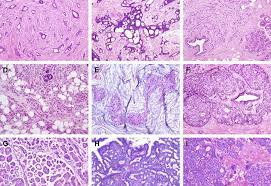

# <span style="color: #FF5733; font-family: 'Arial', sans-serif; font-size: 30px;">Importing libraries</span>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import keras
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.applications import *
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# <span style="color: #FF5733; font-family: 'Arial', sans-serif; font-size: 30px;">Reading data</span>


In [2]:
Image_size = 224
input_shape = (224,224,3)

In [3]:
train_dir = '/kaggle/input/dataset/train'
test_dir = '/kaggle/input/dataset/test'
val_dir= '/kaggle/input/dataset/val'

In [4]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,rotation_range=45, width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True).flow_from_directory(
              directory = os.path.join(train_dir),
              target_size=(Image_size,Image_size),
              batch_size =32,shuffle=True,
             class_mode='categorical')

Found 4946 images belonging to 2 classes.


In [5]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input,rotation_range=45, width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True).flow_from_directory(
              directory = os.path.join(test_dir),
              target_size=(Image_size,Image_size),
              batch_size =32,shuffle=True,
             class_mode='categorical')

Found 126 images belonging to 2 classes.


In [6]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input,rotation_range=45, width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True).flow_from_directory(
              directory = os.path.join(val_dir),
              target_size=(Image_size,Image_size),
              batch_size =32,shuffle=True,
             class_mode='categorical')

Found 120 images belonging to 2 classes.


In [7]:
list(train_gen.class_indices.keys())

['Normal', 'OSCC']

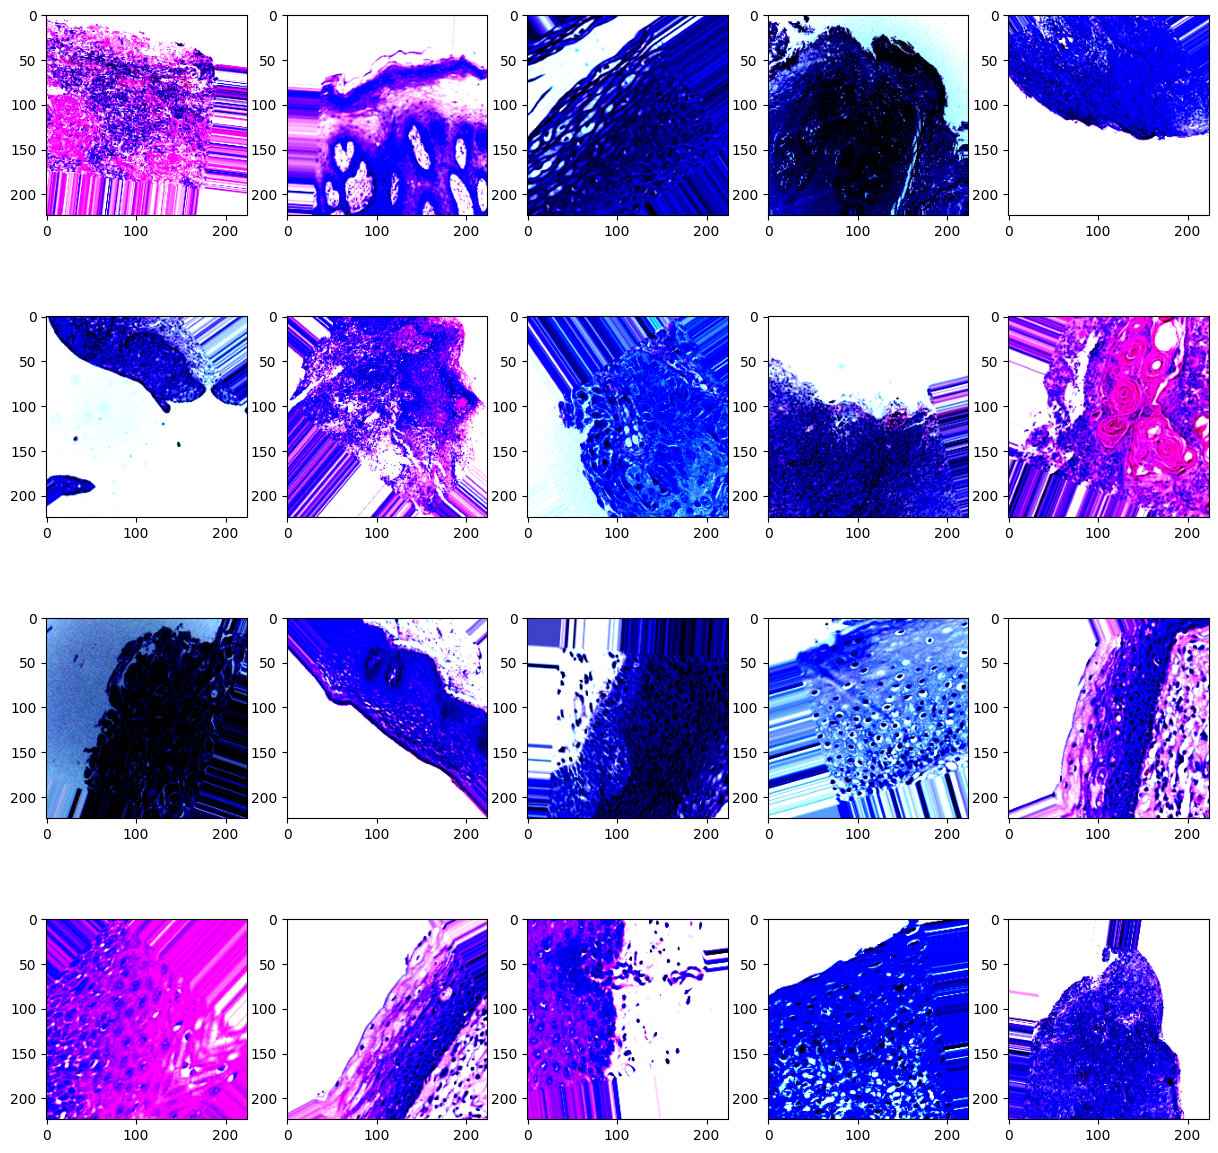

In [8]:
plt.figure(figsize=(15,15))
for batch_x,batch_y in train_gen:    
    for i in range(0,20):
        plt.subplot(4,5,i+1)
        plt.imshow(batch_x[i])
    plt.show()
    break

In [9]:
list(test_gen.class_indices.keys())

['Normal', 'OSCC']

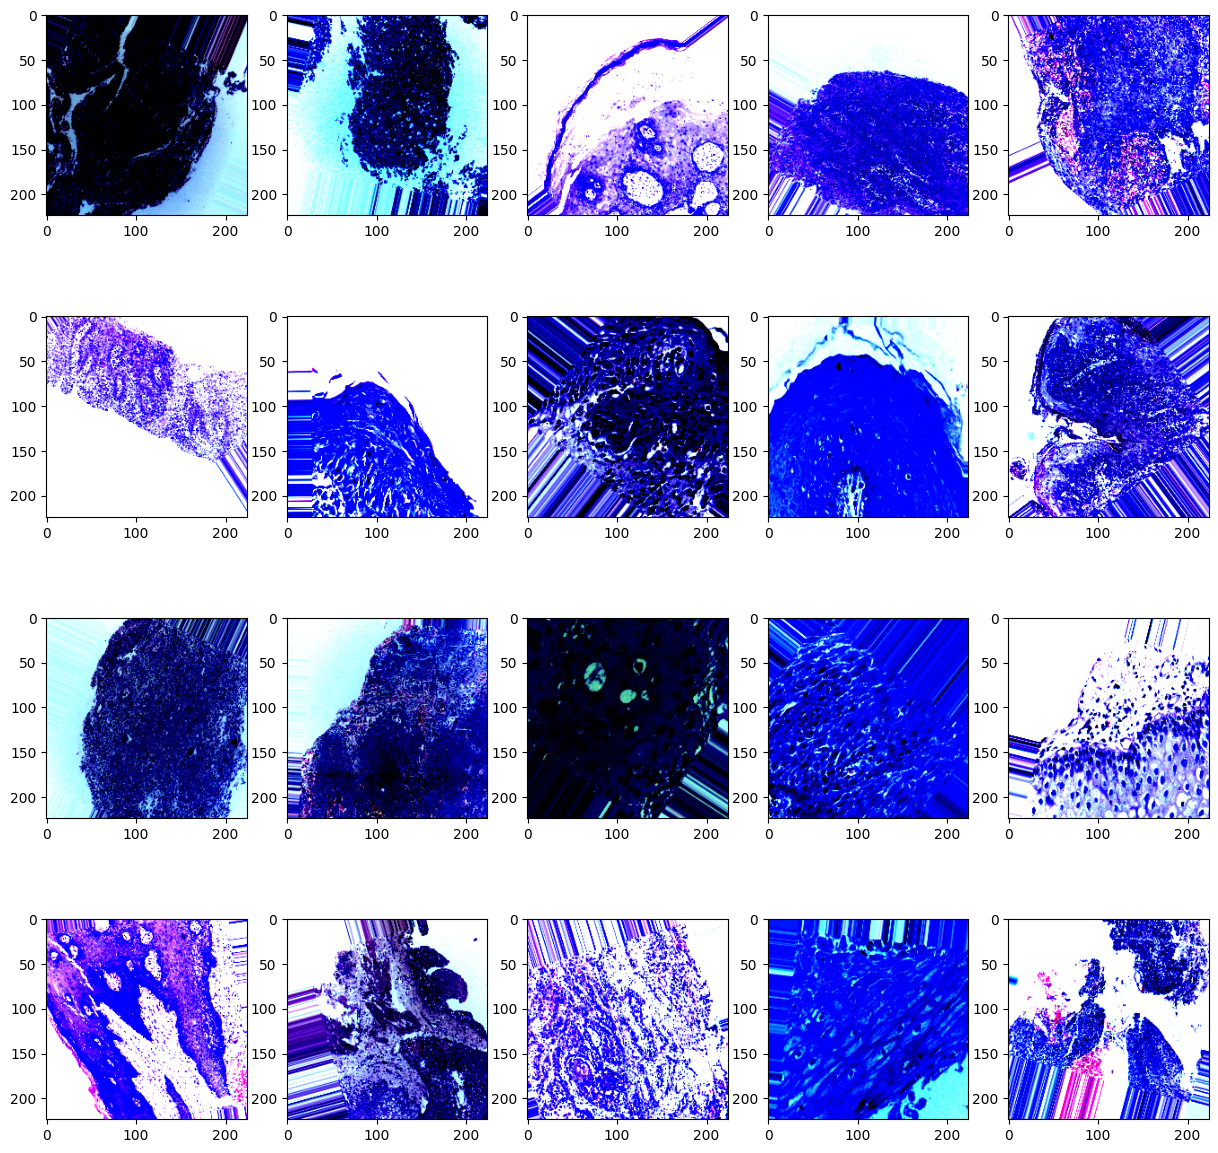

In [10]:
plt.figure(figsize=(15,15))
for batch_x,batch_y in test_gen:    
    for i in range(0,20):
        plt.subplot(4,5,i+1)
        plt.imshow(batch_x[i])
    plt.show()
    break

# <span style="color: #FF5733; font-family: 'Arial', sans-serif; font-size: 30px;">   Model </span>


In [11]:
model =tf.keras.applications.DenseNet201(
    include_top=False,
    input_shape=input_shape,
    weights='imagenet'
)
model.trainable = False

74836368/74836368 [==============================] - 3s 0us/step


In [12]:
input_layer = tf.keras.layers.Input(shape=input_shape)
x = model(input_layer,training=False)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024,activation='relu',kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(2,activation='softmax')(x)

model = tf.keras.Model(inputs=[input_layer],outputs=[output])

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 1920)       7680      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 94080)             0         
                                                                 
 dense (Dense)               (None, 1024)              96338944  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                             

In [14]:
model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[
"accuracy"])

In [15]:
history = model.fit_generator(train_gen,validation_data=val_gen,epochs=10,
                         callbacks=tf.keras.callbacks.EarlyStopping(patience=3,monitor='val_accuracy',restore_best_weights=True),verbose=True)

/tmp/ipykernel_26/3865008522.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,validation_data=val_gen,epochs=10,


Epoch 1/10
155/155 [==============================] - 250s 1s/step - loss: 10.6192 - accuracy: 0.7232 - val_loss: 5.1787 - val_accuracy: 0.8000
Epoch 2/10
155/155 [==============================] - 127s 819ms/step - loss: 4.9003 - accuracy: 0.7487 - val_loss: 3.6952 - val_accuracy: 0.7250
Epoch 3/10
155/155 [==============================] - 127s 819ms/step - loss: 2.9321 - accuracy: 0.7740 - val_loss: 2.1982 - val_accuracy: 0.8083
Epoch 4/10
155/155 [==============================] - 127s 820ms/step - loss: 1.9152 - accuracy: 0.7889 - val_loss: 2.1568 - val_accuracy: 0.7167
Epoch 5/10
155/155 [==============================] - 117s 754ms/step - loss: 1.5758 - accuracy: 0.7960 - val_loss: 1.3477 - val_accuracy: 0.7917
Epoch 6/10
155/155 [==============================] - 117s 757ms/step - loss: 1.3116 - accuracy: 0.7976 - val_loss: 1.1880 - val_accuracy: 0.7833


# <span style="color: #FF5733; font-family: 'Arial', sans-serif; font-size: 30px;">  Training history (loss) </span>


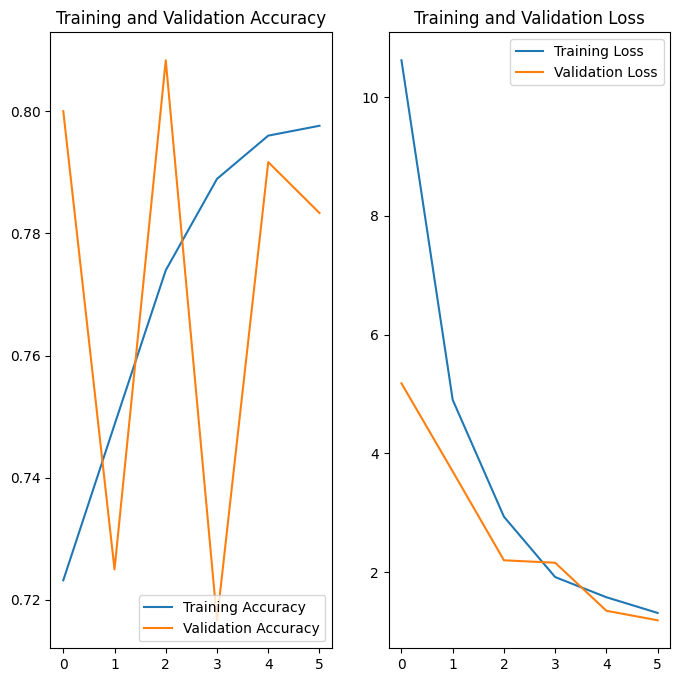

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
model.evaluate(test_gen)

4/4 [==============================] - 16s 5s/step - loss: 2.2123 - accuracy: 0.7937


[2.212326765060425, 0.7936508059501648]

In [18]:
predictions =model.predict(test_gen)

4/4 [==============================] - 11s 2s/step


In [19]:
predictions[:5]

array([[1.9477328e-03, 9.9805224e-01],
       [1.2974006e-01, 8.7025994e-01],
       [7.7617958e-02, 9.2238206e-01],
       [3.8117674e-01, 6.1882323e-01],
       [5.7960351e-05, 9.9994206e-01]], dtype=float32)

In [20]:
y_test = []
y_test_int = []
for i in tqdm(range(len(test_gen))):
    y_test += test_gen[i][1].tolist()
    y_test_int += test_gen[i][1].argmax(axis=1).tolist()
y_test = np.array(y_test)
y_test_int = np.array(y_test_int)

100%|██████████| 4/4 [00:15<00:00,  3.85s/it]


In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix
y_pred_test = model.predict(test_gen, verbose=1)
y_pred_test_int = y_pred_test.argmax(axis=1)
print(y_pred_test,y_pred_test_int)

4/4 [==============================] - 8s 2s/step
[[7.34195888e-01 2.65804082e-01]
 [9.69461381e-01 3.05386204e-02]
 [3.53632241e-01 6.46367729e-01]
 [5.00509858e-01 4.99490142e-01]
 [1.99825037e-02 9.80017543e-01]
 [6.77367330e-01 3.22632611e-01]
 [4.40805423e-04 9.99559224e-01]
 [1.42267812e-03 9.98577356e-01]
 [1.75195232e-01 8.24804783e-01]
 [1.25801831e-01 8.74198139e-01]
 [2.92345155e-02 9.70765531e-01]
 [2.52207518e-02 9.74779248e-01]
 [8.65940601e-02 9.13405955e-01]
 [6.03051603e-01 3.96948367e-01]
 [8.43954682e-01 1.56045347e-01]
 [1.64856464e-02 9.83514309e-01]
 [1.11178614e-01 8.88821363e-01]
 [1.42165027e-06 9.99998569e-01]
 [8.86093453e-02 9.11390662e-01]
 [2.81963110e-01 7.18036890e-01]
 [3.43120075e-04 9.99656916e-01]
 [9.17038182e-04 9.99082923e-01]
 [9.71887052e-01 2.81128976e-02]
 [7.46282518e-01 2.53717542e-01]
 [2.23603565e-02 9.77639675e-01]
 [4.78040101e-03 9.95219529e-01]
 [1.08205333e-01 8.91794682e-01]
 [6.91494823e-01 3.08505177e-01]
 [9.99216795e-01 7.8315928

              precision    recall  f1-score   support

      NORMAL       0.49      0.58      0.53        31
        OSCC       0.85      0.80      0.83        95

    accuracy                           0.75       126
   macro avg       0.67      0.69      0.68       126
weighted avg       0.76      0.75      0.75       126



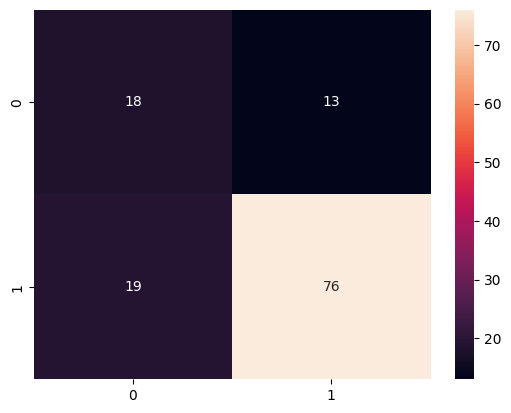

In [22]:
import seaborn as sn
from sklearn.metrics import classification_report
cm = confusion_matrix(y_test_int, y_pred_test_int)
sn.heatmap(cm,annot=True,fmt="d")

target_names = ['NORMAL','OSCC']
print(classification_report(y_test_int, y_pred_test_int, target_names=target_names))